<a href="https://colab.research.google.com/github/mahshidkhatiri/MachineLearning/blob/main/weather_perdiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import glob
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from bs4 import BeautifulSoup
import urllib.request
import requests
import datetime

In [4]:
'''start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2022, 12, 31)
current_date = start_date
month=''
day=''
while current_date <= end_date:
      URL="https://climate.weather.gc.ca/radar/index_e.html?site=CASKR&year="+str(current_date.year)+"&month="+str(current_date.month)+"&day="+str(current_date.day)+"&hour=04&minute=00&duration=24&image_type=COMP_PRECIPET_RAIN_WEATHEROFFICE"
      page = requests.get(URL_before_2023)
      soup = BeautifulSoup(page.content, "html.parser")
      result = soup.find("span",class_="image-container")
      if result is not None:
        result=result.find("img")
        url=result["src"]
        if current_date.month<10:
            month='0'+str(current_date.month)
        else:
            month=str(current_date.month)
        if current_date.day<10:
            day='0'+str(current_date.day)
        else:
            day=str(current_date.day)
        urllib.request.urlretrieve(url, 'drive/MyDrive/dataset'+str(current_date.year)+'/'+str(current_date.year)+'-'+month+'-'+day+'.png')
      '''


'start_date = datetime.date(2018, 1, 1)\nend_date = datetime.date(2022, 12, 31)\ncurrent_date = start_date\nmonth=\'\'\nday=\'\'\nwhile current_date <= end_date:\n      URL_before_2023="https://climate.weather.gc.ca/radar/index_e.html?site=CASKR&year="+str(current_date.year)+"&month="+str(current_date.month)+"&day="+str(current_date.day)+"&hour=04&minute=00&duration=24&image_type=COMP_PRECIPET_RAIN_WEATHEROFFICE"\n      page = requests.get(URL_before_2023)\n      soup = BeautifulSoup(page.content, "html.parser")\n      result = soup.find("span",class_="image-container")\n      if result is not None:\n        result=result.find("img")\n        url=result["src"]\n        if current_date.month<10:\n            month=\'0\'+str(current_date.month)\n        else:\n            month=str(current_date.month)\n        if current_date.day<10:\n            day=\'0\'+str(current_date.day)\n        else:\n            day=str(current_date.day)\n        urllib.request.urlretrieve(url, \'drive/MyDrive/

In [5]:

tabular_data= pd.DataFrame()
for year in [2016,2017,2018,2019,2020,2021,2022,2023]:
            df_temp = pd.read_csv('drive/MyDrive/CSV_files/'+str(year)+'.csv', parse_dates=True)
            if year==2023:
              tabular_data = pd.concat([tabular_data, df_temp[:303]], axis=0)
            else:
              tabular_data = pd.concat([tabular_data, df_temp], axis=0)

tabular_data=tabular_data.drop(['Longitude (x)', 'Latitude (y)','Station Name','Data Quality','Max Temp Flag','Min Temp Flag','Climate ID','Mean Temp Flag','Heat Deg Days Flag'
                                ,'Cool Deg Days Flag','Total Rain (mm)','Total Snow (cm)','Total Snow Flag','Total Rain Flag','Total Precip Flag','Snow on Grnd (cm)',
                                'Snow on Grnd Flag','Dir of Max Gust (10s deg)','Dir of Max Gust Flag','Spd of Max Gust (km/h)','Spd of Max Gust Flag','Cool Deg Days (°C)','Total Precip (mm)'], axis=1)
dataset=tabular_data.drop(['Date/Time','Year','Month','Day'], axis=1)
dataset = dataset.apply(pd.to_numeric, errors='coerce')
column_headers = list(dataset.columns.values)
for column in column_headers:
  dataset[column]=dataset[column].replace(np.nan,dataset[column].mean(axis = 0, skipna = True))
for column in column_headers:
  tabular_data[column]=dataset[column]

dataset[:]

,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C)
0,0.70000,-2.900000,-1.100000,19.100000
1,1.50000,-2.900000,-0.700000,18.700000
2,2.30000,-10.100000,-3.900000,21.900000
3,-9.90000,-14.200000,-12.100000,30.100000
4,14.21524,-13.100000,10.329131,8.960043
...,...,...,...,...
298,18.10000,14.300000,16.200000,1.800000
299,21.90000,16.300000,19.100000,0.000000
300,18.00000,7.500000,12.700000,5.300000
301,7.80000,3.800000,5.800000,12.200000


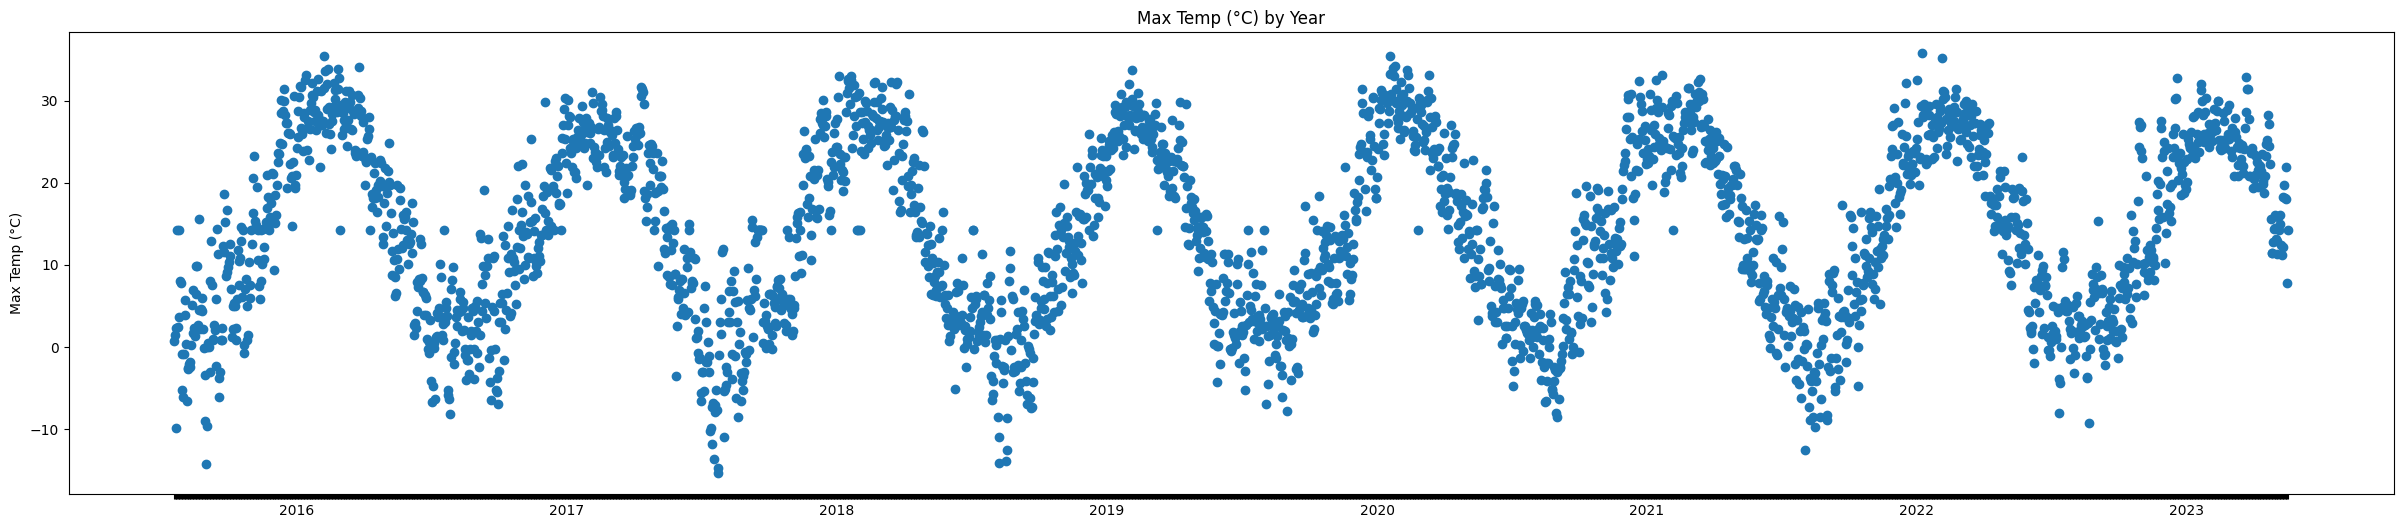

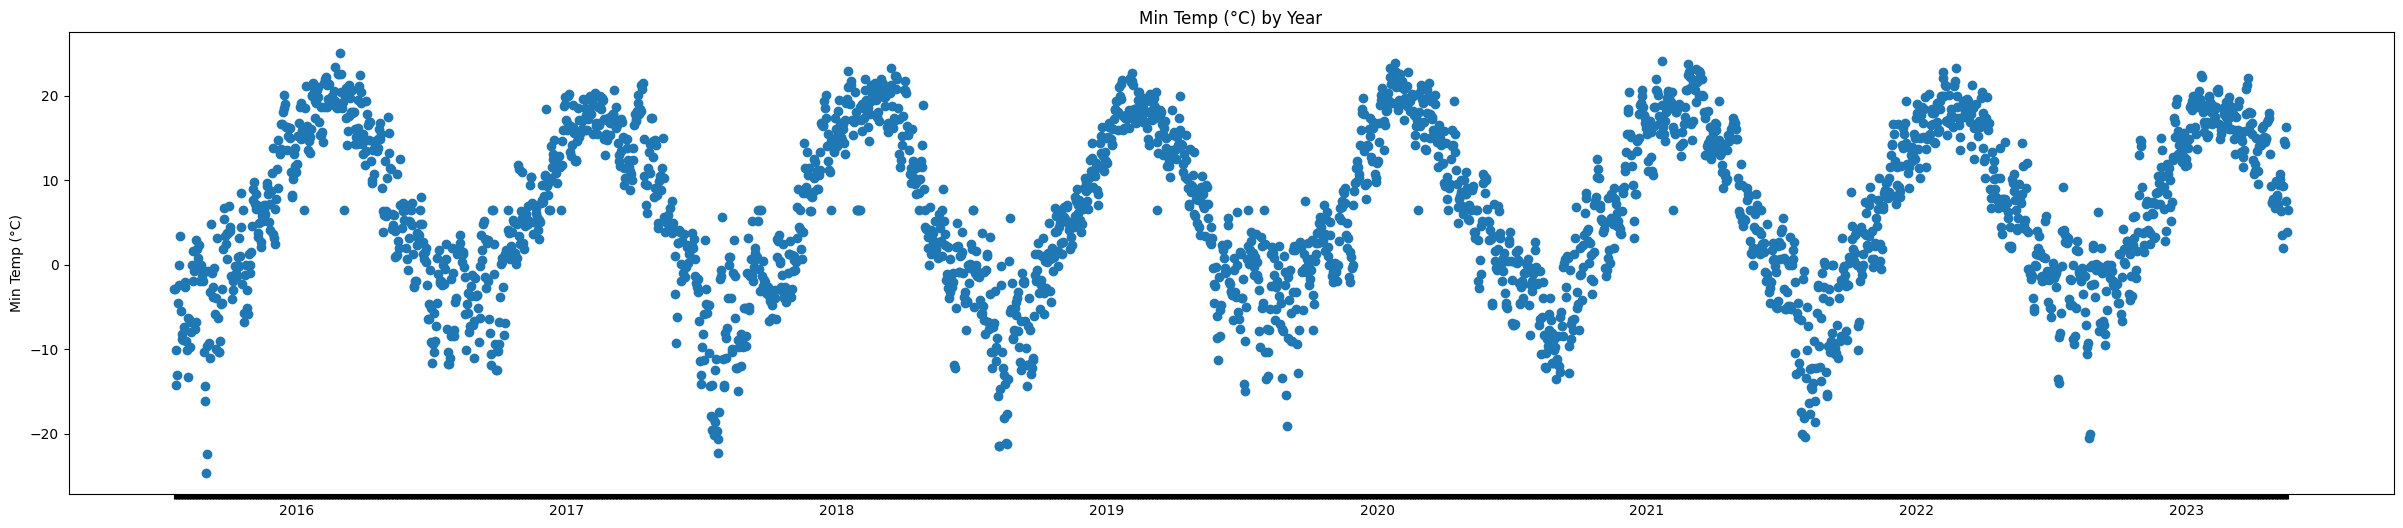

In [6]:
def draw_plot(column):
  plt.figure(figsize=(30, 6))
  plt.scatter(tabular_data['Date/Time'].astype(str), tabular_data[column])
  plt.ylabel(column)
  plt.title(column+' by Year')
  unique_years = tabular_data['Year'].unique()
  list_label=[]
  for date in tabular_data['Date/Time']:
      if date.split('-')[1] == '06' and  date.split('-')[2]== '15':
        list_label.append(date.split('-')[0])
      else:
        list_label.append('')
  plt.xticks(tabular_data['Date/Time'],list_label)
  plt.show()
draw_plot('Max Temp (°C)')
draw_plot('Min Temp (°C)')

In [7]:
train=dataset[:1461]
validation=dataset [1461:2192]
test=dataset[2192:2859]
train_y_1=dataset [['Mean Temp (°C)']][1:1462]
validation_y_1=dataset[['Mean Temp (°C)']][1462:2193]
test_y_1=dataset[['Mean Temp (°C)']][2193:]
scalers = {}
dataset_scaled = dataset.copy()
for column in train.columns:
      scalers[column] =  MinMaxScaler()
      train[column] = scalers[column].fit_transform(train[column].values.reshape((-1, 1))).ravel()
      validation[column] = scalers[column].transform(validation[column].values.reshape((-1, 1))).ravel()
      test[column] = scalers[column].transform(test[column].values.reshape((-1, 1))).ravel()
      dataset_scaled[column]= scalers[column].transform(dataset[column].values.reshape((-1, 1))).ravel()
      if column in train_y_1.columns:
        train_y_1[column] = scalers[column].transform(train_y_1[column].values.reshape((-1, 1))).ravel()
        validation_y_1[column] = scalers[column].transform(validation_y_1[column].values.reshape((-1, 1))).ravel()
        test_y_1[column] = scalers[column].transform(test_y_1[column].values.reshape((-1, 1))).ravel()


In [8]:

model_1= keras.models.Sequential()
model_1.add(keras.layers.Flatten(input_shape=[4]))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dense(64, activation="elu"))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dense(128,activation="relu" ,kernel_initializer="he_normal"))
model_1.add(keras.layers.Dropout(rate=0.2))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dense(64, activation="relu"))
model_1.add(keras.layers.Dropout(rate=0.2))
model_1.add(keras.layers.BatchNormalization())
model_1.add(keras.layers.Dense(1, activation='relu'))
model_1.compile(optimizer = 'SGD',loss = keras.losses.MeanSquaredError())


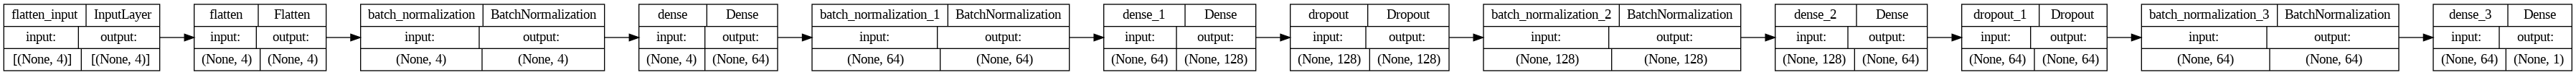

In [9]:
history_1=model_1.fit(train, train_y_1, epochs=50,validation_data=(validation, validation_y_1), verbose=0)
keras.utils.plot_model(model_1, "based_on_one_day.png", show_shapes=True, rankdir='LR')

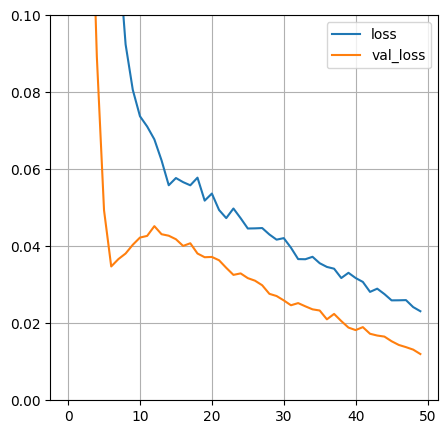

In [10]:
pd.DataFrame(history_1.history).plot(figsize=(5, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.savefig('based_on_one_day_plot.png')
plt.show()

In [11]:
test_p_1= model_1.predict(test)
test_p_1= scalers['Mean Temp (°C)'].inverse_transform(test_p_1).ravel()
test_y_inverse_scaled_1 = scalers['Mean Temp (°C)'].inverse_transform(test_y_1['Mean Temp (°C)'].values.reshape((-1, 1))).ravel()

print("Actual / Predicted")
for i in range(414,424):
  print(test_y_inverse_scaled_1[i].round(1),test_p_1[i].round(2))

21/21 [==============================] - 0s 2ms/step
Actual / Predicted
2.9 5.24
3.1 5.66
-3.5 5.99
-4.1 -12.74
-5.9 -14.39
-4.5 -19.5
0.6 -16.94
-2.3 -0.18
1.3 -8.59
1.6 3.04


In [12]:
def create_sequences(data, sequence_length):
    data= data.values
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length][2]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [13]:
train_sequences, train_targets =create_sequences(dataset_scaled[0:1461],7)
validation_sequences, validation_targets =create_sequences(dataset_scaled[1461:2192],7)
test_sequences, test_targets =create_sequences(dataset_scaled[2192:],7)
sequence_length=7

In [14]:
model_2 = keras.models.Sequential()
model_2.add(keras.layers.LSTM(64, input_shape=(sequence_length, 4), return_sequences=True))
model_2.add(keras.layers.LSTM(64, return_sequences=False))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dense(units = 128,activation="relu" ,kernel_initializer="he_normal"))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dense(units = 32, activation="relu"))
model_2.add(keras.layers.Dropout(rate=0.5))
model_2.add(keras.layers.BatchNormalization())
model_2.add(keras.layers.Dense(1))
model_2.add(keras.layers.LeakyReLU(alpha=0.3))
model_2.compile(optimizer = "SGD",loss = keras.losses.MeanSquaredError())

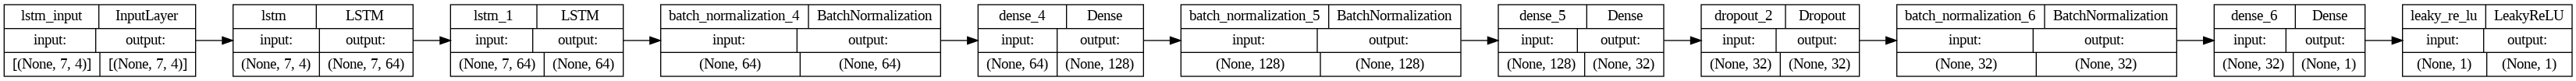

In [15]:
history_2=model_2.fit(train_sequences, train_targets, epochs=50,validation_data=(validation_sequences, validation_targets), verbose=0)
keras.utils.plot_model(model_2, "weekly_by_order.png", show_shapes=True, rankdir='LR')

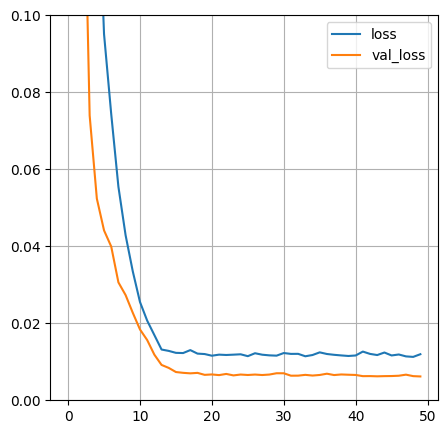

In [16]:
pd.DataFrame(history_2.history).plot(figsize=(5, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.savefig('weekly_by_order_plot.png.png')
plt.show()

In [17]:
test_p_2= model_2.predict(test_sequences)
test_p_2= scalers['Mean Temp (°C)'].inverse_transform(test_p_2).ravel()
test_y_inverse_scaled_2 = scalers['Mean Temp (°C)'].inverse_transform(test_targets.reshape((-1, 1))).ravel()

print("Actual / Predicted")
for i in range(408,428):
  print(test_y_inverse_scaled_2[i].round(1),"   ",test_p_2[i].round(2))

21/21 [==============================] - 1s 3ms/step
Actual / Predicted
2.9     1.48
3.1     1.56
-3.5     1.87
-4.1     1.52
-5.9     0.3
-4.5     -1.91
0.6     -3.68
-2.3     -3.21
1.3     -2.59
1.6     -1.08
2.2     0.17
-0.3     1.28
2.5     1.37
3.3     1.58
1.3     2.29
0.0     2.22
0.3     1.81
1.1     1.36
-0.8     1.23
-1.5     0.54


In [18]:
sequence_length=365
train_sequences_2, train_targets_2 =create_sequences(dataset_scaled[0:1461],sequence_length)
validation_sequences_2, validation_targets_2 =create_sequences(dataset_scaled[1461:2192],sequence_length)
test_sequences_2, test_targets_2 =create_sequences(dataset_scaled[2192:],sequence_length)

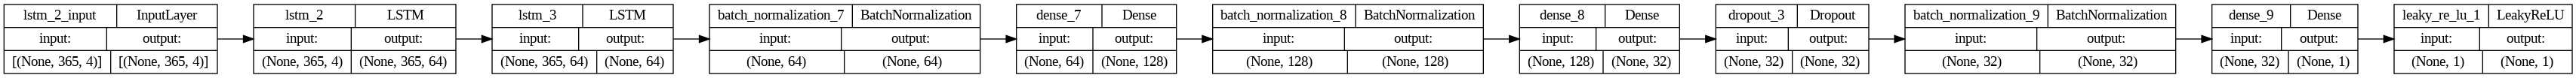

In [19]:
model_3 = keras.models.Sequential()
model_3.add(keras.layers.LSTM(64, input_shape=(sequence_length, 4), return_sequences=True))
model_3.add(keras.layers.LSTM(64, return_sequences=False))
model_3.add(keras.layers.BatchNormalization())
model_3.add(keras.layers.Dense(units = 128,activation="relu" ,kernel_initializer="he_normal"))
model_3.add(keras.layers.BatchNormalization())
model_3.add(keras.layers.Dense(units = 32, activation="relu"))
model_3.add(keras.layers.Dropout(rate=0.5))
model_3.add(keras.layers.BatchNormalization())
model_3.add(keras.layers.Dense(1))
model_3.add(keras.layers.LeakyReLU(alpha=0.3))
model_3.compile(optimizer = "SGD",loss = keras.losses.MeanSquaredError())
history_3=model_3.fit(train_sequences_2, train_targets_2, epochs=50,validation_data=(validation_sequences_2, validation_targets_2), verbose=0)
keras.utils.plot_model(model_3, "yearly_by_order.png", show_shapes=True, rankdir='LR')

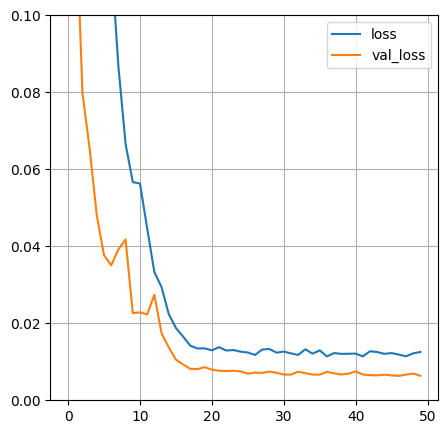

In [20]:
pd.DataFrame(history_3.history).plot(figsize=(5, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.savefig('yearly_by_order_plot.png')
plt.show()

In [21]:
test_p_3= model_3.predict(test_sequences_2)
test_p_3= scalers['Mean Temp (°C)'].inverse_transform(test_p_3).ravel()
test_y_inverse_scaled_3 = scalers['Mean Temp (°C)'].inverse_transform(test_targets_2.reshape((-1, 1))).ravel()

print("Actual / Predicted")
for i in range(50,70):
  print(test_y_inverse_scaled_3[i].round(2)," ",test_p_3[i].round(2))

10/10 [==============================] - 1s 13ms/step
Actual / Predicted
2.9   2.82
3.1   2.93
-3.5   3.04
-4.1   2.69
-5.9   2.22
-4.5   1.39
0.6   0.41
-2.3   0.0
1.3   -0.41
1.6   -0.31
2.2   0.03
-0.3   0.58
2.5   0.92
3.3   1.32
1.3   1.75
0.0   1.93
0.3   1.95
1.1   1.92
-0.8   1.89
-1.5   1.78


In [48]:
image_list = []
file_name=[]

for year in [2018,2019,2020,2021,2022]:
  for filename in glob.glob('drive/MyDrive/dataset'+str(year)+'/*.png'):
    im=Image.open(filename)
    image_2=im.crop((0,0,480,480)).resize((150,150))
    image_2=image_2.convert('RGB')
    name=im.filename.split('/')[-1].split('.')
    file_name.append(name[0])
    img_array = np.array(image_2)/255.0
    image_list.append(img_array)


1826
(150, 150, 3)


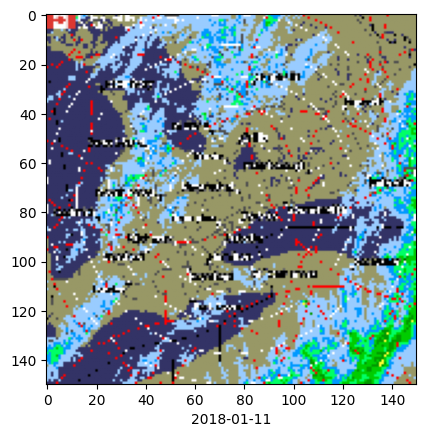

In [49]:
print(len(image_list))
print(image_list[10].shape)
plt.imshow(image_list[10])
plt.xlabel(file_name[10])
plt.savefig('example_of_images.png')
plt.show()

In [61]:
A0=keras.layers.Input(shape=((150,150,3)),name='A0')
A1=tf.keras.layers.Conv2D(64, (5,5), activation='relu')(A0)
A2=tf.keras.layers.MaxPooling2D(3,3)(A1)
A3=tf.keras.layers.Conv2D(128, (5,5), activation='relu')(A2)
A4=tf.keras.layers.MaxPooling2D(3,3)(A3)
A55=keras.layers.Dropout(rate=0.2)(A4)
A5=tf.keras.layers.Conv2D(64, (3,3), activation='relu')(A55)
A6=tf.keras.layers.MaxPooling2D(2,2)(A5)
A7=tf.keras.layers.Flatten()(A6)
A8=tf.keras.layers.Dense(8, activation='linear')(A7)

B0 = keras.layers.Input(shape=(4,),name='B0')
B1 = keras.layers.Dense(16, activation='tanh')(B0)
B2 = keras.layers.Dense(32)(B1)
B3=keras.layers.LeakyReLU(alpha=0.5)(B2)
B4 = keras.layers.Dense(32, activation='tanh')(B3)

concat = tf.keras.layers.concatenate([A8,B4])
c1 = keras.layers.Dense(32)(concat)
c2=keras.layers.Dropout(rate=0.2)(c1)
output = tf.keras.layers.Dense(1,activation='relu',name="output")(c2)
model_4 = tf.keras.Model(inputs=[A0, B0], outputs=[output])
model_4.compile(optimizer = "SGD",loss = keras.losses.MeanSquaredError())

In [51]:
train_4=dataset[731:1827]
validation_4=dataset [1827:2192]
test_4=dataset[2192:2556]
train_y_4=dataset [['Mean Temp (°C)']][732:1828]
validation_y_4=dataset[['Mean Temp (°C)']][1828:2193]
test_y_4=dataset[['Mean Temp (°C)']][2193:2557]
train_pics=image_list[:1096]
validation_pics=image_list[1096:1461]
test_pics=image_list[1461:1825]
for column in train_4.columns:
      train_4[column] = scalers[column].fit_transform(train_4[column].values.reshape((-1, 1))).ravel()
      validation_4[column] = scalers[column].transform(validation_4[column].values.reshape((-1, 1))).ravel()
      test_4[column] = scalers[column].transform(test_4[column].values.reshape((-1, 1))).ravel()
      if column in train_y_4.columns:
        train_y_4[column] = scalers[column].transform(train_y_4[column].values.reshape((-1, 1))).ravel()
        validation_y_4[column] = scalers[column].transform(validation_y_4[column].values.reshape((-1, 1))).ravel()
        test_y_4[column] = scalers[column].transform(test_y_4[column].values.reshape((-1, 1))).ravel()
train_data = tf.convert_to_tensor(train_pics)
validation_data=tf.convert_to_tensor(validation_pics)
train_data.shape

TensorShape([1096, 150, 150, 3])

In [62]:
history_4 = model_4.fit((train_data,train_4), train_y_4, epochs=50,validation_data=((validation_data,validation_4), validation_y_4),verbose=1)

Epoch 1/50
35/35 [==============================] - 4s 64ms/step - loss: 0.0549 - val_loss: 0.0160
Epoch 2/50
35/35 [==============================] - 2s 49ms/step - loss: 0.0291 - val_loss: 0.0133
Epoch 3/50
35/35 [==============================] - 2s 53ms/step - loss: 0.0216 - val_loss: 0.0115
Epoch 4/50
35/35 [==============================] - 2s 46ms/step - loss: 0.0186 - val_loss: 0.0110
Epoch 5/50
35/35 [==============================] - 2s 45ms/step - loss: 0.0164 - val_loss: 0.0070
Epoch 6/50
35/35 [==============================] - 2s 46ms/step - loss: 0.0166 - val_loss: 0.0084
Epoch 7/50
35/35 [==============================] - 2s 46ms/step - loss: 0.0145 - val_loss: 0.0076
Epoch 8/50
35/35 [==============================] - 2s 45ms/step - loss: 0.0145 - val_loss: 0.0061
Epoch 9/50
35/35 [==============================] - 2s 46ms/step - loss: 0.0141 - val_loss: 0.0049
Epoch 10/50
35/35 [==============================] - 2s 47ms/step - loss: 0.0135 - val_loss: 0.0053
Epoch 11/

In [63]:
test_data= tf.convert_to_tensor(test_pics)
test_p_4= model_4.predict((test_data,test_4))
test_p_4= scalers['Mean Temp (°C)'].inverse_transform(test_p_4).ravel()
test_y_inverse_scaled_4 = scalers['Mean Temp (°C)'].inverse_transform(test_y_4['Mean Temp (°C)'].values.reshape((-1, 1))).ravel()

print("Actual / Predicted")
for i in range(20,40):
  print(test_y_inverse_scaled_4[i].round(2)," ",test_p_4[i].round(2))

12/12 [==============================] - 1s 36ms/step
Actual / Predicted
-8.1   -12.54
-9.3   -7.92
-9.2   -8.4
-8.9   -8.41
-11.3   -8.39
-6.0   -10.4
-9.7   -5.94
-14.2   -8.4
-8.2   -13.78
-3.2   -7.58
1.4   -2.94
1.1   1.53
-5.9   0.38
-10.3   -5.59
-10.0   -9.89
-3.1   -9.27
1.1   -3.05
-1.5   1.49
1.4   -1.29
1.9   1.67


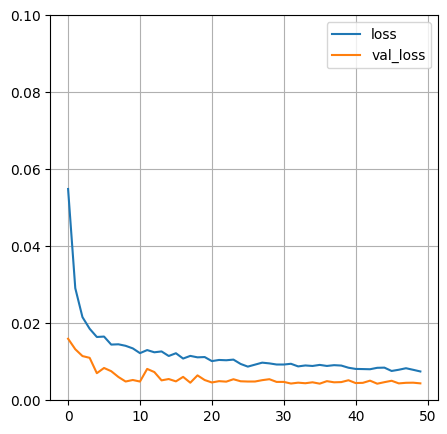

In [64]:
pd.DataFrame(history_4.history).plot(figsize=(5, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.savefig('daily+image_plot.png')
plt.show()

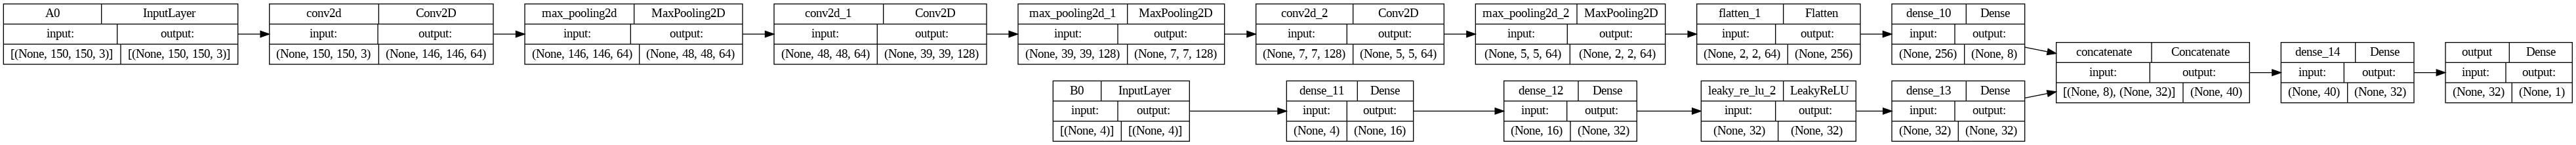

In [28]:
keras.utils.plot_model(model_4, "daily+image.png", show_shapes=True, rankdir='LR')

In [29]:
def create_sequences_2(data, sequence_length_i,sequence_length_o):
    data= data.values
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length_i-sequence_length_o):
        seq = data[i:i+sequence_length_i]
        target = data[i+sequence_length_i:i+sequence_length_i+sequence_length_o,2:3]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [30]:
windowed_dataset,windowed_labels=create_sequences_2(dataset_scaled,7,3)
combined = list(zip(windowed_dataset,windowed_labels))
np.random.shuffle(combined)
windowed_dataset,windowed_labels = zip(*combined)
windowed_dataset=np.array(windowed_dataset)
windowed_labels=np.array(windowed_labels)

In [31]:
total_length = len(windowed_labels)
train_length = int(0.7 * total_length)
val_length = int(0.15 * total_length)

train_y_5 = windowed_labels[:train_length]
train_5 =windowed_dataset[:train_length]

val_y_5 = windowed_labels[train_length:train_length + val_length]
val_5 = windowed_dataset[train_length:train_length + val_length]

test_y_5 = windowed_labels[train_length + val_length:]
test_5 = windowed_dataset[train_length + val_length:]


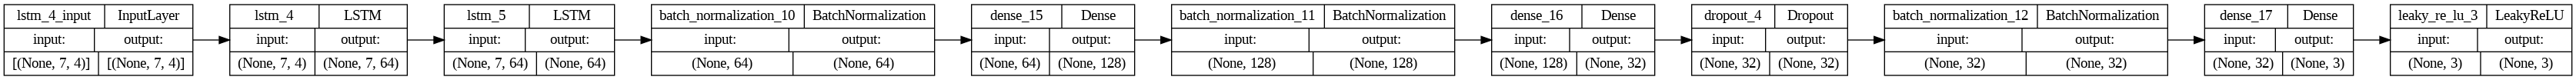

In [32]:
model_5 = keras.models.Sequential()
model_5.add(keras.layers.LSTM(64, input_shape=(7, 4), return_sequences=True))
model_5.add(keras.layers.LSTM(64, return_sequences=False))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dense(units = 128,activation="relu" ,kernel_initializer="he_normal"))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dense(units = 32, activation="relu"))
model_5.add(keras.layers.Dropout(rate=0.5))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dense(3))
model_5.add(keras.layers.LeakyReLU(alpha=0.3))
model_5.compile(optimizer = "SGD",loss = keras.losses.MeanSquaredError())
history_5=model_5.fit(train_5, train_y_5, epochs=50,validation_data=(val_5, val_y_5), verbose=0)
keras.utils.plot_model(model_5, "predict 3 days based on a week.png", show_shapes=True, rankdir='LR')

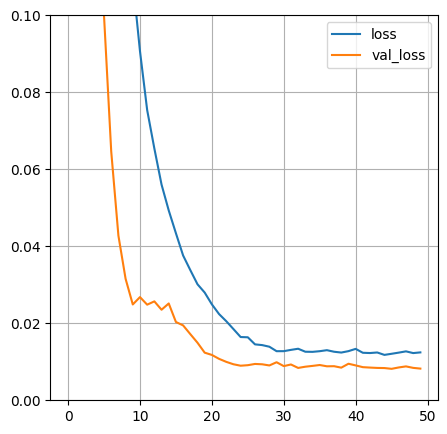

In [33]:
pd.DataFrame(history_5.history).plot(figsize=(5, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.savefig('predict 3 days based on a week_plot.png')
plt.show()

In [34]:

test_p_5= model_5.predict(test_5)
test_p_5= scalers['Mean Temp (°C)'].inverse_transform(test_p_5.flatten().reshape(-1, 1)).ravel()
test_p_5=test_p_5.reshape(-1,3)
test_y_inverse_scaled_5 = scalers['Mean Temp (°C)'].inverse_transform(test_y_5.reshape(-1, 1)).ravel()
test_y_inverse_scaled_5=test_y_inverse_scaled_5.reshape(-1,3)
for i in range(5):
  for j in range(3):
    print("prediction of day "+str(j+1)+" ",test_p_5[i][j].round(1),"/ The Actual measure of day "+str(j+1)+" ",test_y_inverse_scaled_5[i][j].round(1))
    print("________________________________________________________________________________")

14/14 [==============================] - 1s 3ms/step
prediction of day 1  0.9 / The Actual measure of day 1  4.0
________________________________________________________________________________
prediction of day 2  1.0 / The Actual measure of day 2  -0.7
________________________________________________________________________________
prediction of day 3  1.0 / The Actual measure of day 3  -0.3
________________________________________________________________________________
prediction of day 1  9.4 / The Actual measure of day 1  8.1
________________________________________________________________________________
prediction of day 2  9.6 / The Actual measure of day 2  6.9
________________________________________________________________________________
prediction of day 3  9.5 / The Actual measure of day 3  8.2
________________________________________________________________________________
prediction of day 1  3.6 / The Actual measure of day 1  3.2
_______________________________________